In [1]:
!pip install tensorflow opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 539.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 106.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 108.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.6 MB/s eta 0:00:00


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!pip install kaggle
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset
!unzip new-plant-diseases-dataset.zip -d new-plant-diseases-dataset


Streaming output truncated to the last 5000 lines.
  inflating: new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Stra

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [4]:
dir_name = "/content/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
batch_s = 32
img_h = 128
img_w = 128
seed = 123

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    dir_name,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=(img_h, img_w),
    batch_size=batch_s
)
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    dir_name,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(img_h, img_w),
    batch_size=batch_s
)

Found 70295 files belonging to 38 classes.
Using 56236 files for training.
Found 70295 files belonging to 38 classes.
Using 14059 files for validation.


In [5]:
class_name = train_data.class_names
class_name

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
#model 1 : CNN
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_h, img_w, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_name),activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [9]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1758/1758 ━━━━━━━━━━━━━━━━━━━━ 1495s 843ms/step - accuracy: 0.4757 - loss: 1.8682 - val_accuracy: 0.8412 - val_loss: 0.4911
Epoch 2/5
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 1430s 813ms/step - accuracy: 0.8559 - loss: 0.4536 - val_accuracy: 0.8752 - val_loss: 0.3861
Epoch 3/5
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 1422s 809ms/step - accuracy: 0.9071 - loss: 0.2858 - val_accuracy: 0.9109 - val_loss: 0.2707
Epoch 4/5
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 1427s 812ms/step - accuracy: 0.9312 - loss: 0.2069 - val_accuracy: 0.9272 - val_loss: 0.2343
Epoch 5/5
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 1426s 811ms/step - accuracy: 0.9473 - loss: 0.1568 - val_accuracy: 0.9283 - val_loss: 0.2275


In [11]:
loss, accuracy = model.evaluate(val_data)
print(f"Validation Accuracy: {accuracy:.2f}")

440/440 ━━━━━━━━━━━━━━━━━━━━ 87s 197ms/step - accuracy: 0.9321 - loss: 0.2150
Validation Accuracy: 0.93


In [15]:
val_images = []
val_labels = []

for img_batch, label_batch in val_data:
    val_images.append(img_batch)
    val_labels.append(label_batch)

val_images = tf.concat(val_images, axis=0)
val_labels = tf.concat(val_labels, axis=0)

pred_probs = model.predict(val_images)
pred_classes = np.argmax(pred_probs, axis=1)

440/440 ━━━━━━━━━━━━━━━━━━━━ 90s 203ms/step


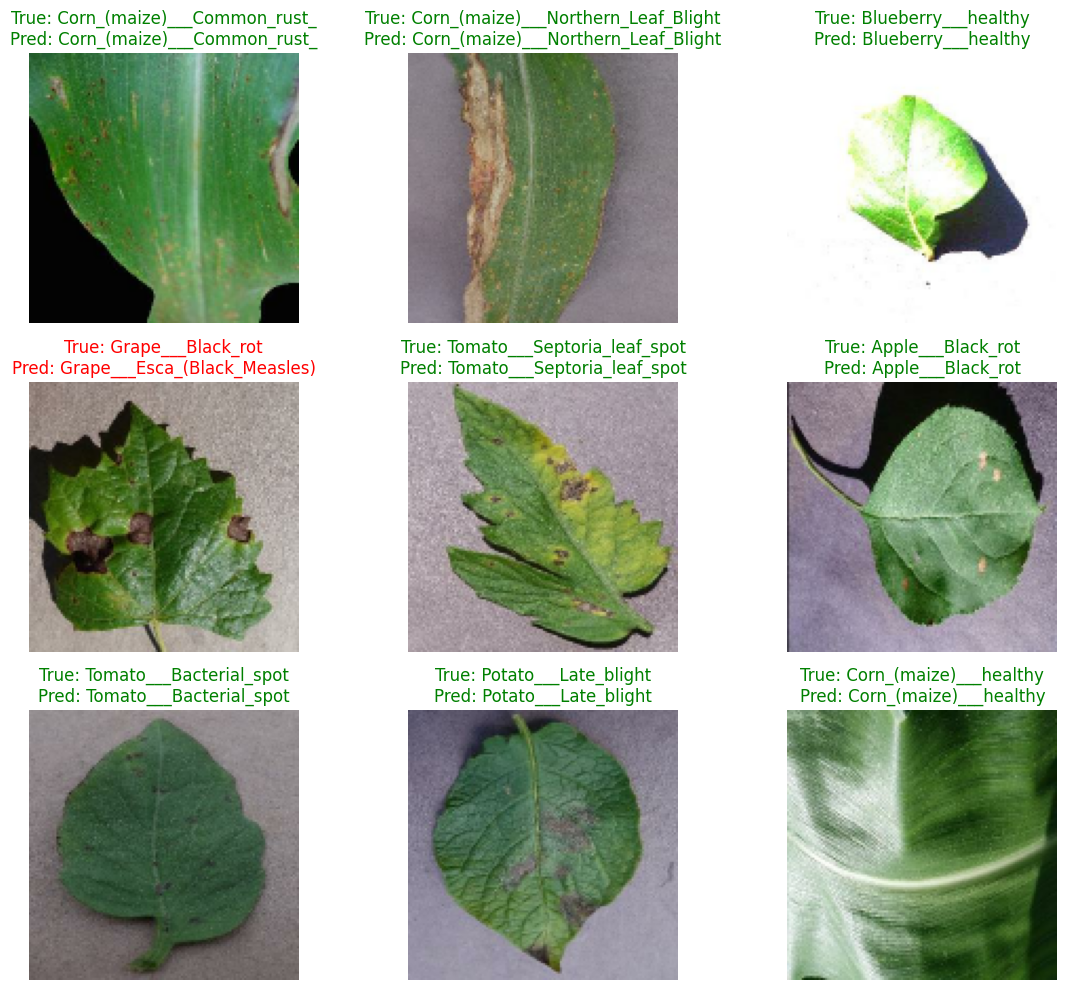

In [16]:
plt.figure(figsize=(12, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(val_images[i].numpy().astype("uint8"))
    true_label = class_name[val_labels[i]]
    pred_label = class_name[pred_classes[i]]
    color = "green" if true_label == pred_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis("off")
plt.tight_layout()
plt.show()

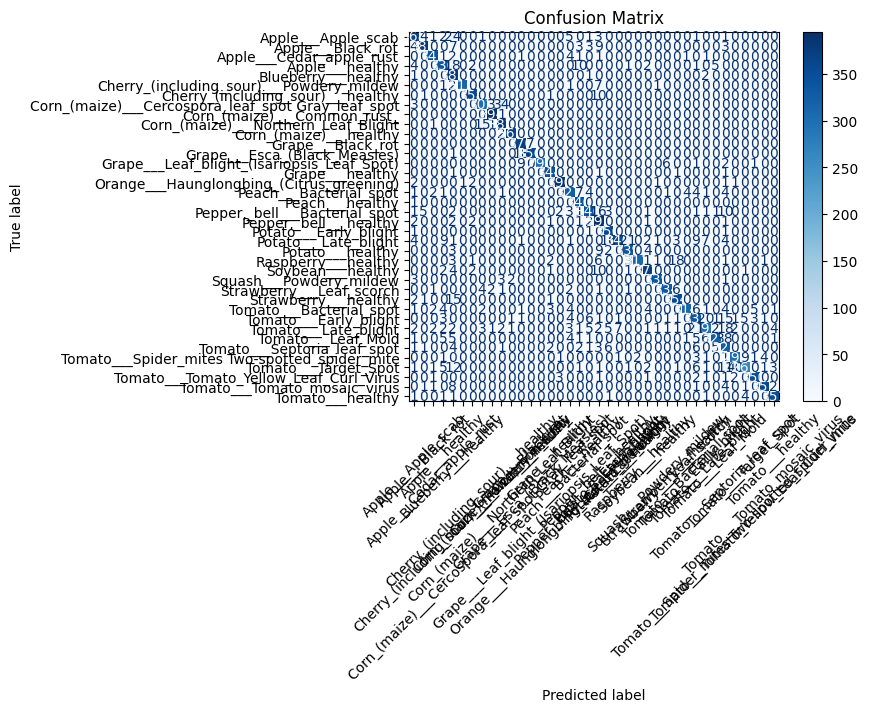

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(val_labels, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_name)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


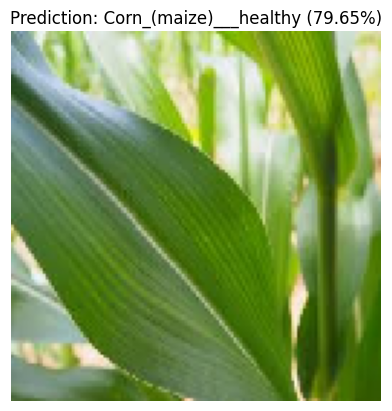

Predicted: Corn_(maize)___healthy with 79.65% confidence


In [23]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def predict_plant_disease(img_path, model, class_names, img_height, img_width): # Pass img_h, img_w
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0]) * 100

    predicted_label = class_names[predicted_class]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_label} ({confidence:.2f}%)")
    plt.show()

    return predicted_label, confidence

img_path = "/content/images.jpg"
label, confidence = predict_plant_disease(img_path, model, class_name, img_h, img_w)
print(f"Predicted: {label} with {confidence:.2f}% confidence")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


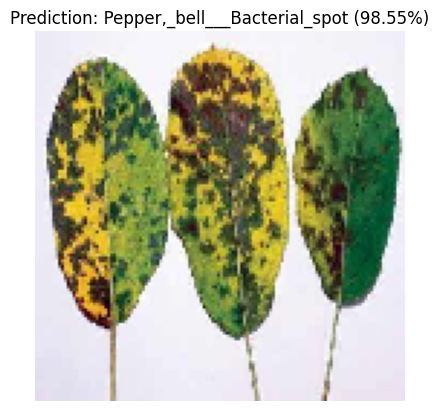

Predicted: Pepper,_bell___Bacterial_spot with 98.55% confidence


In [24]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def predict_plant_disease(img_path, model, class_names, img_height, img_width): # Pass img_h, img_w
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0]) * 100

    predicted_label = class_names[predicted_class]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_label} ({confidence:.2f}%)")
    plt.show()

    return predicted_label, confidence

img_path = "/content/Marssoninaleafblotch.jpg"
label, confidence = predict_plant_disease(img_path, model, class_name, img_h, img_w)
print(f"Predicted: {label} with {confidence:.2f}% confidence")